In [1]:
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pydataset import data
import plotly
import plotly.graph_objs as go
import eli5

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# Acquire Data

In [2]:
df=get_telco_data()

Using cached csv


In [3]:
# First look at data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
df.head(2)

payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                2                         1                 2  0002-ORFBO   
1                2                         1                 1  0003-MKNFE   

   gender  senior_citizen partner dependents  tenure phone_service  \
0  Female               0     Yes        Yes       9           Yes   
1    Male               0      No         No       9           Yes   

  multiple_lines online_security online_backup device_protection tech_support  \
0             No              No           Yes                No          Yes   
1            Yes              No            No                No           No   

  streaming_tv streaming_movies paperless_billing  monthly_charges  \
0          Yes               No               Yes             65.6   
1           No              Yes                No             59.9   

  total_charges churn   contract_type internet_service_type  payment_type  
0         593.3    No        One year                   DSL  Mailed check  
1         542.4    No  Month-to-month                   DSL  Mailed check

## <span style="color:red">Acquire Takeaway:</span>

### Initial Groups identified

Customer groups
 - Senior citizen
 - Male vs. Female
 - Partner vs. No Partner
 - Dependent vs No Dependents

Business Groups
 - Auto vs Manual Pay
 - paperless billing vs mailed
 - month-to-month vs contracted
 - Internet vs no Internet
 - Phone vs No phone

# Prepare Section

In [5]:
# Prep telco to drop and encode columns
df=prep_telco(df)

In [6]:
df.head()

customer_id  is_senior_citizen  tenure multiple_lines online_security  \
0  0002-ORFBO                  0       9             No              No   
1  0003-MKNFE                  0       9            Yes              No   
2  0004-TLHLJ                  0       4             No              No   
3  0011-IGKFF                  1      13             No              No   
4  0013-EXCHZ                  1       3             No              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No          Yes          Yes               No   
1            No                No           No           No              Yes   
2            No               Yes           No           No               No   
3           Yes               Yes           No          Yes              Yes   
4            No                No          Yes          Yes               No   

   monthly_charges  total_charges  churn   contract_type  \
0             65.6         593.30      0        One year   
1             59.9         542.40      0  Month-to-month   
2             73.9         280.85      1  Month-to-month   
3             98.0        1237.85      1  Month-to-month   
4             83.9         267.40      1  Month-to-month   

  internet_service_type      payment_type  is_male  has_phone  \
0                   DSL      Mailed check        0          1   
1                   DSL      Mailed check        1          1   
2           Fiber optic  Electronic check        1          1   
3           Fiber optic  Electronic check        1          1   
4           Fiber optic      Mailed check        0          1   

   has_internet_service  has_partner  has_dependent  is_paperless  \
0                     1            1              1             1   
1                     1            0              0             0   
2                     1            0              0             1   
3                     1            1              0             1   
4                     1            1              0             1   

   is_month_to_month  is_autopay  has_streaming  
0                  0           0           True  
1                  1           0           True  
2                  1           0          False  
3                  1           0           True  
4                  1           0           True

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7032 non-null   object 
 1   is_senior_citizen      7032 non-null   int64  
 2   tenure                 7032 non-null   int64  
 3   multiple_lines         7032 non-null   object 
 4   online_security        7032 non-null   object 
 5   online_backup          7032 non-null   object 
 6   device_protection      7032 non-null   object 
 7   tech_support           7032 non-null   object 
 8   streaming_tv           7032 non-null   object 
 9   streaming_movies       7032 non-null   object 
 10  monthly_charges        7032 non-null   float64
 11  total_charges          7032 non-null   float64
 12  churn                  7032 non-null   int64  
 13  contract_type          7032 non-null   object 
 14  internet_service_type  7032 non-null   object 
 15  paym

In [8]:
df.describe()

is_senior_citizen       tenure  monthly_charges  total_charges  \
count        7032.000000  7032.000000      7032.000000    7032.000000   
mean            0.162400    32.421786        64.798208    2283.300441   
std             0.368844    24.545260        30.085974    2266.771362   
min             0.000000     1.000000        18.250000      18.800000   
25%             0.000000     9.000000        35.587500     401.450000   
50%             0.000000    29.000000        70.350000    1397.475000   
75%             0.000000    55.000000        89.862500    3794.737500   
max             1.000000    72.000000       118.750000    8684.800000   

             churn      is_male    has_phone  has_internet_service  \
count  7032.000000  7032.000000  7032.000000           7032.000000   
mean      0.265785     0.504693     0.903299              0.783845   
std       0.441782     0.500014     0.295571              0.411650   
min       0.000000     0.000000     0.000000              0.000000   
25%       0.000000     0.000000     1.000000              1.000000   
50%       0.000000     1.000000     1.000000              1.000000   
75%       1.000000     1.000000     1.000000              1.000000   
max       1.000000     1.000000     1.000000              1.000000   

       has_partner  has_dependent  is_paperless  is_month_to_month  \
count  7032.000000    7032.000000   7032.000000        7032.000000   
mean      0.482509       0.298493      0.592719           0.551052   
std       0.499729       0.457629      0.491363           0.497422   
min       0.000000       0.000000      0.000000           0.000000   
25%       0.000000       0.000000      0.000000           0.000000   
50%       0.000000       0.000000      1.000000           1.000000   
75%       1.000000       1.000000      1.000000           1.000000   
max       1.000000       1.000000      1.000000           1.000000   

        is_autopay  
count  7032.000000  
mean      0.435580  
std       0.495868  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [9]:
df.head()

customer_id  is_senior_citizen  tenure multiple_lines online_security  \
0  0002-ORFBO                  0       9             No              No   
1  0003-MKNFE                  0       9            Yes              No   
2  0004-TLHLJ                  0       4             No              No   
3  0011-IGKFF                  1      13             No              No   
4  0013-EXCHZ                  1       3             No              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No          Yes          Yes               No   
1            No                No           No           No              Yes   
2            No               Yes           No           No               No   
3           Yes               Yes           No          Yes              Yes   
4            No                No          Yes          Yes               No   

   monthly_charges  total_charges  churn   contract_type  \
0             65.6         593.30      0        One year   
1             59.9         542.40      0  Month-to-month   
2             73.9         280.85      1  Month-to-month   
3             98.0        1237.85      1  Month-to-month   
4             83.9         267.40      1  Month-to-month   

  internet_service_type      payment_type  is_male  has_phone  \
0                   DSL      Mailed check        0          1   
1                   DSL      Mailed check        1          1   
2           Fiber optic  Electronic check        1          1   
3           Fiber optic  Electronic check        1          1   
4           Fiber optic      Mailed check        0          1   

   has_internet_service  has_partner  has_dependent  is_paperless  \
0                     1            1              1             1   
1                     1            0              0             0   
2                     1            0              0             1   
3                     1            1              0             1   
4                     1            1              0             1   

   is_month_to_month  is_autopay  has_streaming  
0                  0           0           True  
1                  1           0           True  
2                  1           0          False  
3                  1           0           True  
4                  1           0           True

In [10]:
# Determine the categorical variables - here defined as object data type (non-numeric) and with fewer than 5 values
catcol = df.columns[(df.nunique()<5)&(df.dtypes == 'object')]
# Encode categoricals
dummy_df = pd.get_dummies(df[catcol], dummy_na=False, drop_first=True)
# Concatenate dummy df to original df
df = pd.concat([df,dummy_df],axis=1)
# Remove the original categorical columns after encoding
df = df.drop(columns=catcol)

In [11]:
train, validate, test = train_validate_test_split(df, target = 'churn')
train.shape, validate.shape, test.shape

((3937, 36), (1688, 36), (1407, 36))

In [12]:
# creating second dataframe for Chi2 analysis
df2 = train.drop(columns = ['customer_id'])

In [59]:
df2.head(5)

is_senior_citizen  tenure  monthly_charges  total_charges  churn  \
5919                  0      58            71.10        4299.20      0   
1915                  0      71            85.45        6028.95      0   
5054                  0      35            25.75         882.55      0   
2355                  0       1            19.20          19.20      0   
6279                  1      20            54.00        1055.90      0   

      is_male  has_phone  has_internet_service  has_partner  has_dependent  \
5919        0          1                     1            0              0   
1915        1          1                     1            0              1   
5054        0          1                     0            1              1   
2355        1          1                     0            1              1   
6279        1          1                     1            0              0   

      is_paperless  is_month_to_month  is_autopay  has_streaming  \
5919             1                  0           1          False   
1915             1                  0           1          False   
5054             1                  1           0          False   
2355             0                  1           0          False   
6279             0                  0           0          False   

      multiple_lines_No phone service  multiple_lines_Yes  \
5919                                0                   1   
1915                                0                   1   
5054                                0                   1   
2355                                0                   0   
6279                                0                   0   

      online_security_No internet service  online_security_Yes  \
5919                                    0                    1   
1915                                    0                    1   
5054                                    1                    0   
2355                                    1                    0   
6279                                    0                    1   

      online_backup_No internet service  online_backup_Yes  \
5919                                  0                  1   
1915                                  0                  1   
5054                                  1                  0   
2355                                  1                  0   
6279                                  0                  0   

      device_protection_No internet service  device_protection_Yes  \
5919                                      0                      1   
1915                                      0                      0   
5054                                      1                      0   
2355                                      1                      0   
6279                                      0                      0   

      tech_support_No internet service  tech_support_Yes  \
5919                                 0                 1   
1915                                 0                 0   
5054                                 1                 0   
2355                                 1                 0   
6279                                 0                 1   

      streaming_tv_No internet service  streaming_tv_Yes  \
5919                                 0                 0   
1915                                 0                 0   
5054                                 1                 0   
2355                                 1                 0   
6279                                 0                 0   

      streaming_movies_No internet service  streaming_movies_Yes  \
5919                                     0                     0   
1915                                     0                     0   
5054                                     1                     0   
2355                                     1                     0   
6279                                     0                     

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   is_senior_citizen                      3937 non-null   int64  
 1   tenure                                 3937 non-null   int64  
 2   monthly_charges                        3937 non-null   float64
 3   total_charges                          3937 non-null   float64
 4   churn                                  3937 non-null   int64  
 5   is_male                                3937 non-null   int64  
 6   has_phone                              3937 non-null   int64  
 7   has_internet_service                   3937 non-null   int64  
 8   has_partner                            3937 non-null   int64  
 9   has_dependent                          3937 non-null   int64  
 10  is_paperless                           3937 non-null   int64  
 11  i

In [14]:
df2.describe()

is_senior_citizen       tenure  monthly_charges  total_charges  \
count        3937.000000  3937.000000      3937.000000    3937.000000   
mean            0.161290    32.775210        64.805131    2316.775641   
std             0.367845    24.709604        30.294804    2284.984394   
min             0.000000     1.000000        18.250000      18.850000   
25%             0.000000     9.000000        34.700000     396.100000   
50%             0.000000    30.000000        70.250000    1414.800000   
75%             0.000000    56.000000        90.300000    3893.600000   
max             1.000000    72.000000       118.650000    8594.400000   

             churn      is_male    has_phone  has_internet_service  \
count  3937.000000  3937.000000  3937.000000           3937.000000   
mean      0.265685     0.501905     0.905258              0.779782   
std       0.441753     0.500060     0.292896              0.414447   
min       0.000000     0.000000     0.000000              0.000000   
25%       0.000000     0.000000     1.000000              1.000000   
50%       0.000000     1.000000     1.000000              1.000000   
75%       1.000000     1.000000     1.000000              1.000000   
max       1.000000     1.000000     1.000000              1.000000   

       has_partner  has_dependent  is_paperless  is_month_to_month  \
count  3937.000000    3937.000000   3937.000000        3937.000000   
mean      0.485141       0.302769      0.590297           0.549911   
std       0.499843       0.459514      0.491841           0.497566   
min       0.000000       0.000000      0.000000           0.000000   
25%       0.000000       0.000000      0.000000           0.000000   
50%       0.000000       0.000000      1.000000           1.000000   
75%       1.000000       1.000000      1.000000           1.000000   
max       1.000000       1.000000      1.000000           1.000000   

        is_autopay  multiple_lines_No phone service  multiple_lines_Yes  \
count  3937.000000                      3937.000000         3937.000000   
mean      0.446279                         0.094742            0.423927   
std       0.497169                         0.292896            0.494242   
min       0.000000                         0.000000            0.000000   
25%       0.000000                         0.000000            0.000000   
50%       0.000000                         0.000000            0.000000   
75%       1.000000                         0.000000            1.000000   
max       1.000000                         1.000000            1.000000   

       online_security_No internet service  online_security_Yes  \
count                          3937.000000          3937.000000   
mean                              0.220218             0.292609   
std                               0.414447             0.455018   
min                               0.000000             0.000000   
25%                               0.000000             0.000000   
50%                               0.000000             0.000000   
75%                               0.000000             1.000000   
max                               1.000000             1.000000   

       online_backup_No internet service  online_backup_Yes  \
count                        3937.000000        3937.000000   
mean                            0.220218           0.348743   
std                             0.414447           0.476633   
min                             0.000000           0.000000   
25%                             0.000000           0.000000   
50%                             0.000000           0.000000   
75%                             0.000000           1.000000   
max                             1.000000           1.000000   

       device_protection_No internet service  device_protection_Yes  \
count                            3937.000000            3937.000000   
mean                                0.220218               0.349759   
std                       

### <span style="color:red">Prepare Takeaway </span>
- data is split (train, validate, Test)
- Data is encoded
- prepare.py file dropped NA values
- some values were renamed (see data dictionary)
- Data dictionary will have list of updates

- No insight into the data

# Explore (EDA) Stage

### Univariate Stats:
    - for quantitative variables: histogram, boxplot and compute descriptive stats.

In [15]:
numerics = df2.columns[df2.dtypes=='float64']

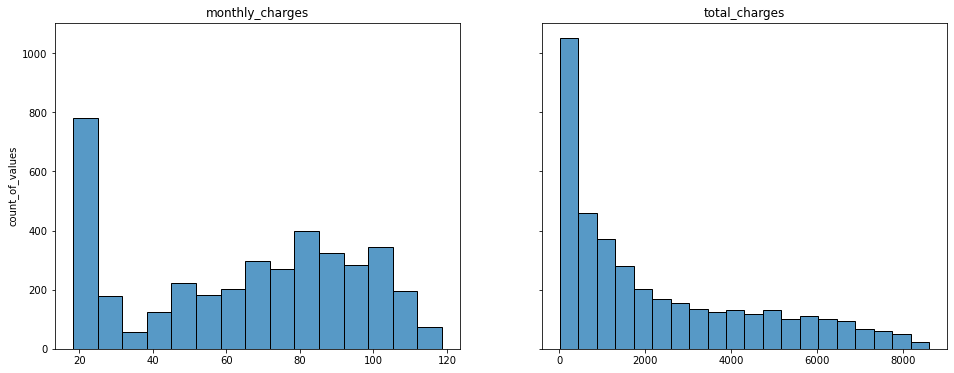

In [16]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
for i,col in enumerate(numerics):
    sns.histplot(x=col, data=df2, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('count_of_values')
    ax[i].set_title(col)

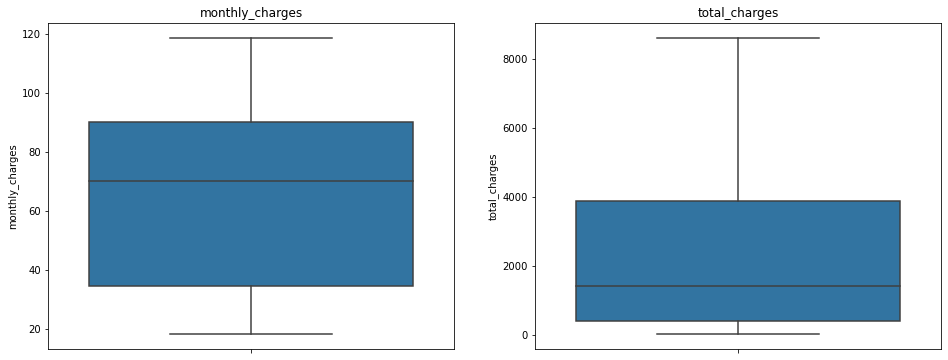

In [17]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i,col in enumerate(numerics):
    sns.boxplot(y=col, data=df2, ax=ax[i])
    ax[i].set_title(col)

In [18]:
df2.describe().T

count         mean          std  \
is_senior_citizen                      3937.0     0.161290     0.367845   
tenure                                 3937.0    32.775210    24.709604   
monthly_charges                        3937.0    64.805131    30.294804   
total_charges                          3937.0  2316.775641  2284.984394   
churn                                  3937.0     0.265685     0.441753   
is_male                                3937.0     0.501905     0.500060   
has_phone                              3937.0     0.905258     0.292896   
has_internet_service                   3937.0     0.779782     0.414447   
has_partner                            3937.0     0.485141     0.499843   
has_dependent                          3937.0     0.302769     0.459514   
is_paperless                           3937.0     0.590297     0.491841   
is_month_to_month                      3937.0     0.549911     0.497566   
is_autopay                             3937.0     0.446279     0.497169   
multiple_lines_No phone service        3937.0     0.094742     0.292896   
multiple_lines_Yes                     3937.0     0.423927     0.494242   
online_security_No internet service    3937.0     0.220218     0.414447   
online_security_Yes                    3937.0     0.292609     0.455018   
online_backup_No internet service      3937.0     0.220218     0.414447   
online_backup_Yes                      3937.0     0.348743     0.476633   
device_protection_No internet service  3937.0     0.220218     0.414447   
device_protection_Yes                  3937.0     0.349759     0.476954   
tech_support_No internet service       3937.0     0.220218     0.414447   
tech_support_Yes                       3937.0     0.289307     0.453498   
streaming_tv_No internet service       3937.0     0.220218     0.414447   
streaming_tv_Yes                       3937.0     0.386335     0.486971   
streaming_movies_No internet service   3937.0     0.220218     0.414447   
streaming_movies_Yes                   3937.0     0.391415     0.488129   
contract_type_One year                 3937.0     0.207010     0.405215   
contract_type_Two year                 3937.0     0.243078     0.428997   
internet_service_type_Fiber optic      3937.0     0.437389     0.496127   
internet_service_type_None             3937.0     0.220218     0.414447   
payment_type_Credit card (automatic)   3937.0     0.227330     0.419161   
payment_type_Electronic check          3937.0     0.327407     0.469327   
payment_type_Mailed check              3937.0     0.226314     0.418498   

                                         min    25%      50%     75%      max  
is_senior_citizen                       0.00    0.0     0.00     0.0     1.00  
tenure                                  1.00    9.0    30.00    56.0    72.00  
monthly_charges                        18.25   34.7    70.25    90.3   118.65  
total_charges                          18.85  396.1  1414.80  3893.6  8594.40  
churn                                   0.00    0.0     0.00     1.0     1.00  
is_male                                 0.00    0.0     1.00     1.0     1.00  
has_phone                               0.00    1.0     1.00     1.0     1.00  
has_internet_service                    0.00    1.0     1.00     1.0     1.00  
has_partner                             0.00    0.0     0.00     1.0     1.00  
has_dependent                           0.00    0.0     0.00     1.0     1.00  
is_paperless                            0.00    0.0     1.00     1.0     1.00  
is_month_to_month                       0.00    0.0     1.00     1.0     1.00  
is_autopay                              0.00    0.0     0.00     1.0     1.00  
multiple_lines_No phone service         0.00    0.0     0.00     0.0     1.00  
multiple_lines_Yes                      0.00    0.0     0.00     1.0     1.00  
online_security_No internet service     0.00    0.0     0.00     0.0     1.00  
online_security_Yes                     0.00    0.0   

### Hypothesis
- H0 is there is no relationship between variable and churn
- Ha is there is a relationship between variable and churn

Variables:
Customer-
is_male
is_senior_citizen
has_partner
has_dependent

Business-
is_paperless
is_autopay
is_month_to_month
has_phone
has_internet_service
has_streaming

In [54]:
# Loop through variables - Tookout observed rates for final product - uncomment to see
alpha = 0.05
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service','has_streaming']
reject_null = []
churn_rate=[]
baseline_churn = (df2.churn == 1).mean()
for group in groups:
    observed = pd.crosstab(df2.churn, df2[group])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    print(group)
    #print('Observed\n')
    #print(observed.values)
    #print('---\nExpected\n')
    #print(expected.astype(int))
    #print('---\n')
    #print(f'chi^2 = {chi2:.4f}')
    #print(f'p     = {p:.4f}')
    if p < alpha:
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")
    churn_rate.append((df2.churn[df2[group] == 1]).mean())
    reject_null.append(p<alpha)
    
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
results = results.sort_values(by= 'churn_rate')

is_male
We fail to reject the null hypothesis
is_senior_citizen
We reject the null hypothesis
has_partner
We reject the null hypothesis
has_dependent
We reject the null hypothesis
is_paperless
We reject the null hypothesis
is_autopay
We reject the null hypothesis
is_month_to_month
We reject the null hypothesis
has_phone
We fail to reject the null hypothesis
has_internet_service
We reject the null hypothesis
has_streaming
We reject the null hypothesis


In [52]:
baseline_churn

0.2656845313690627

In [20]:
results

churn_rate  reject_null
has_dependent           0.156040         True
is_autopay              0.167331         True
has_partner             0.200524         True
is_male                 0.265688        False
has_phone               0.267957        False
has_streaming           0.295408         True
has_internet_service    0.319870         True
is_paperless            0.335628         True
is_senior_citizen       0.426772         True
is_month_to_month       0.428176         True

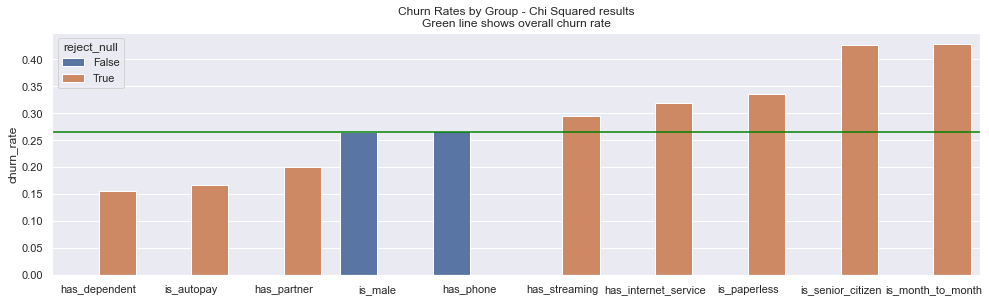

In [21]:
baseline_churn = (df2.churn == 1).mean()
sns.set(rc={'figure.figsize':(14,4)})
sns.barplot(data = results, x = results.index ,y = 'churn_rate', hue = 'reject_null')
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nGreen line shows overall churn rate')
plt.axhline(y=baseline_churn, color = 'green')
# plt.bar_label(splot.containers[0])

   multiple_lines_No phone service_counts
0                                    3564
1                                     373


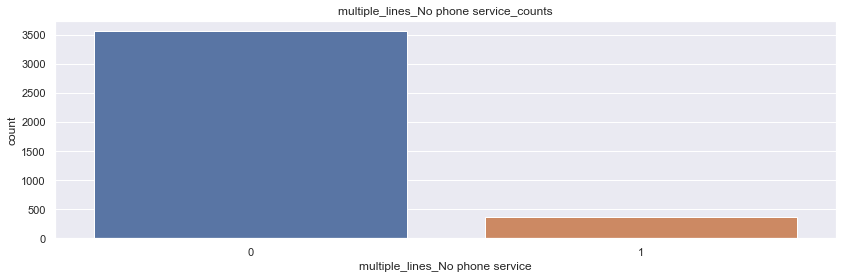

   multiple_lines_Yes_counts
0                       2268
1                       1669


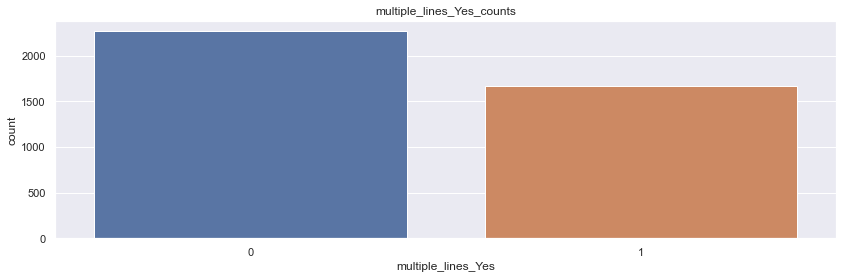

   online_security_No internet service_counts
0                                        3070
1                                         867


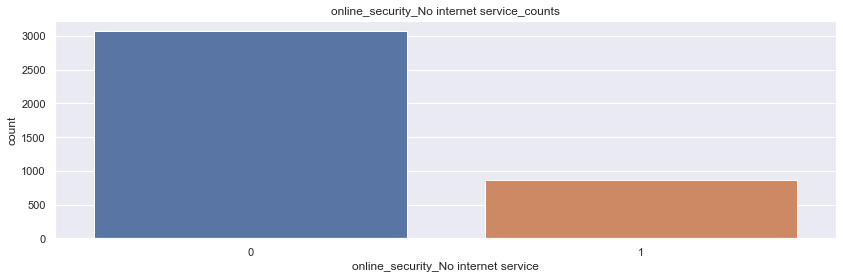

   online_security_Yes_counts
0                        2785
1                        1152


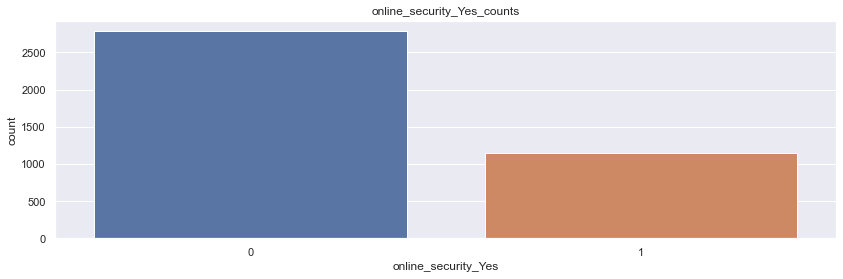

   online_backup_No internet service_counts
0                                      3070
1                                       867


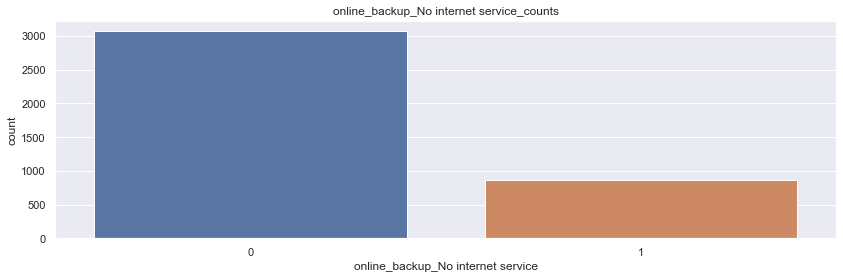

   online_backup_Yes_counts
0                      2564
1                      1373


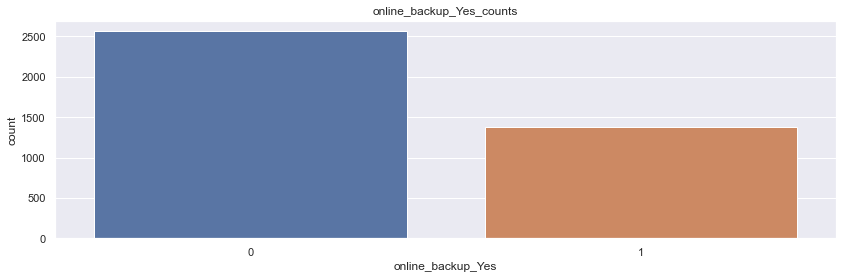

   device_protection_No internet service_counts
0                                          3070
1                                           867


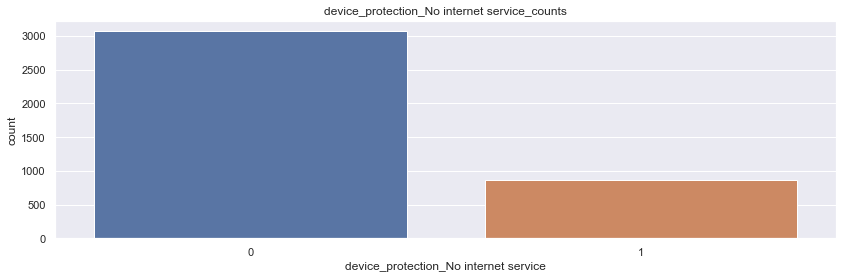

   device_protection_Yes_counts
0                          2560
1                          1377


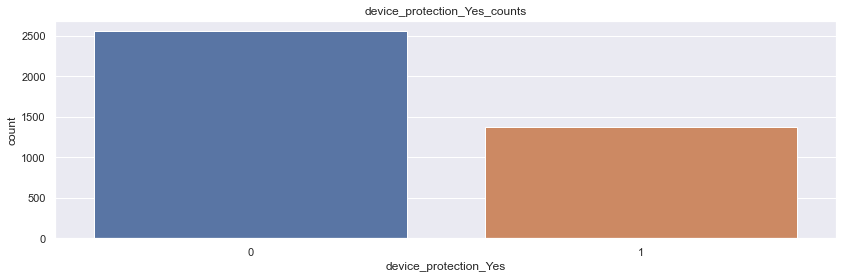

   tech_support_No internet service_counts
0                                     3070
1                                      867


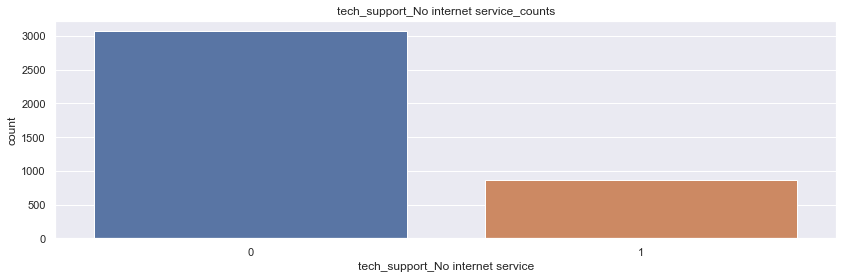

   tech_support_Yes_counts
0                     2798
1                     1139


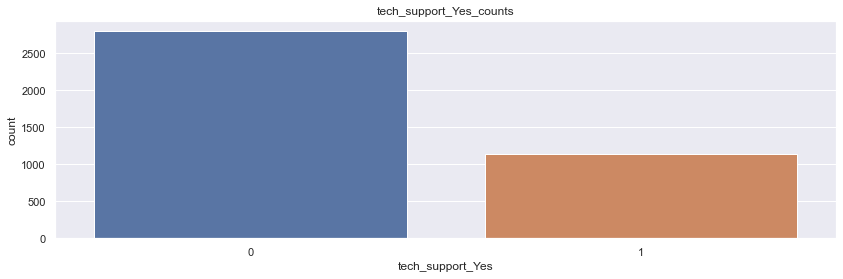

   streaming_tv_No internet service_counts
0                                     3070
1                                      867


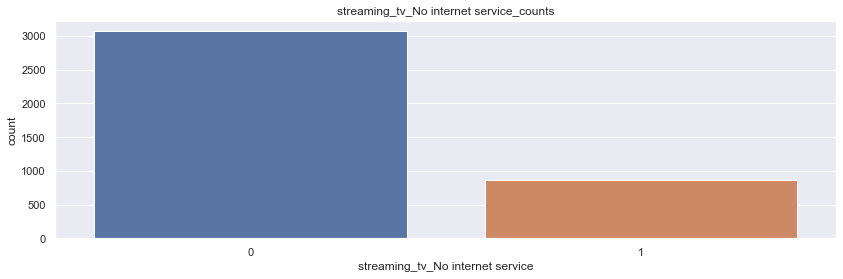

   streaming_tv_Yes_counts
0                     2416
1                     1521


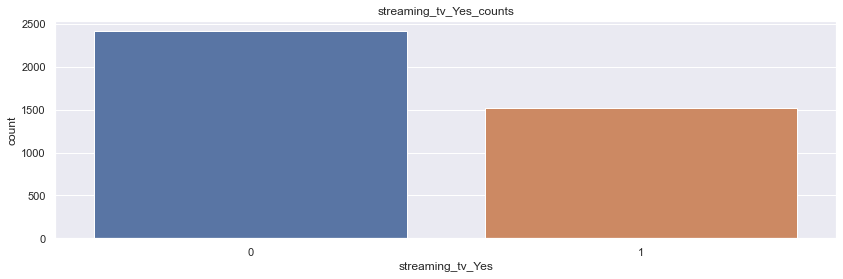

   streaming_movies_No internet service_counts
0                                         3070
1                                          867


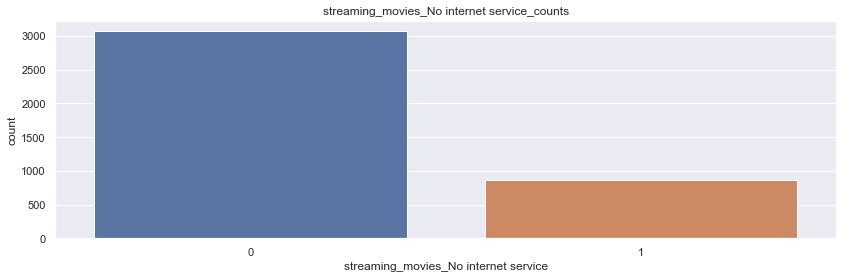

   streaming_movies_Yes_counts
0                         2396
1                         1541


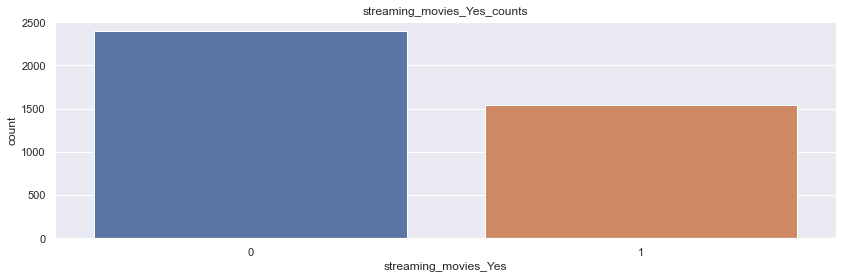

   contract_type_One year_counts
0                           3122
1                            815


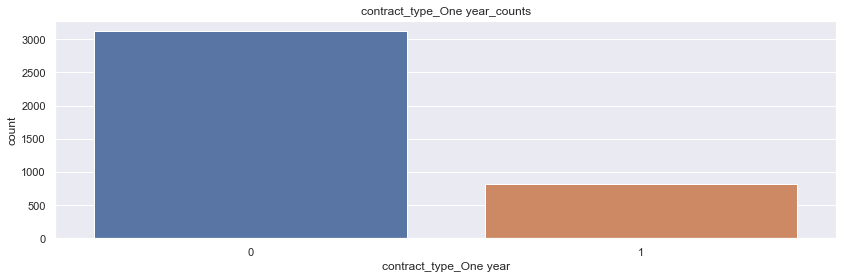

   contract_type_Two year_counts
0                           2980
1                            957


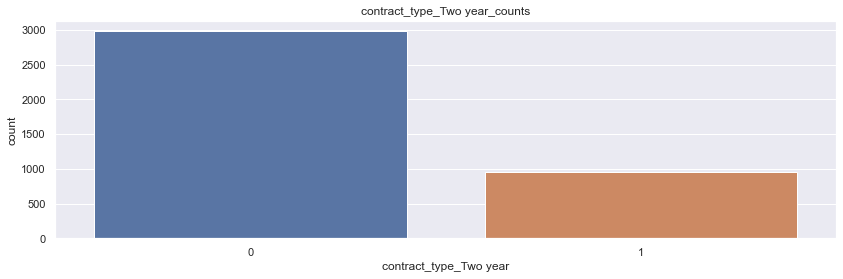

   internet_service_type_Fiber optic_counts
0                                      2215
1                                      1722


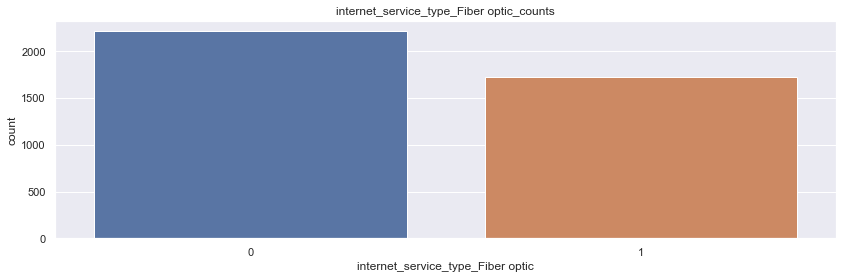

   internet_service_type_None_counts
0                               3070
1                                867


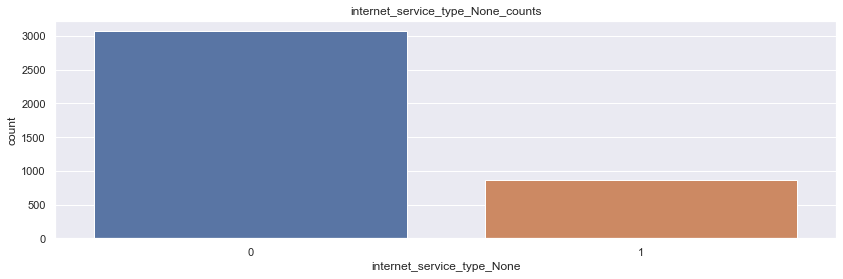

   payment_type_Credit card (automatic)_counts
0                                         3042
1                                          895


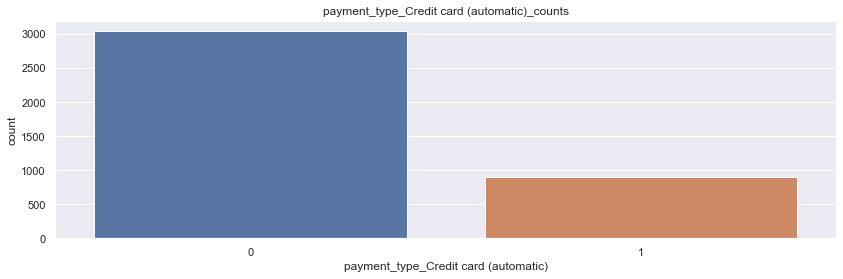

   payment_type_Electronic check_counts
0                                  2648
1                                  1289


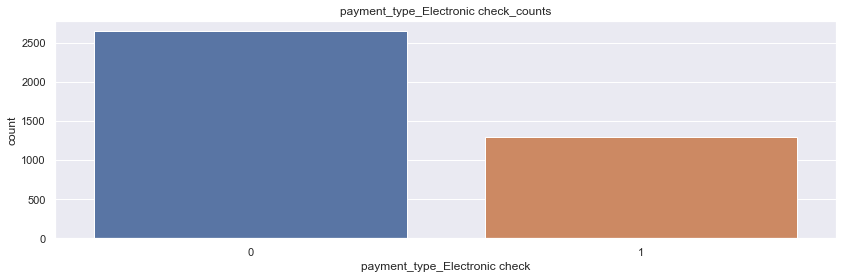

   payment_type_Mailed check_counts
0                              3046
1                               891


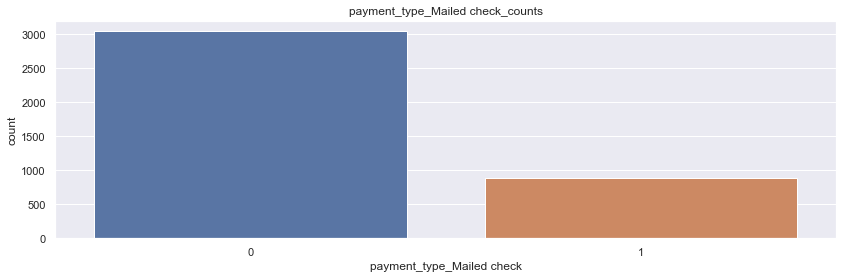

In [22]:

# Create visual of categorical column counts, looking for which categories demonstrate high churn counts.

categorical_columns = list(train.dtypes[train.dtypes == 'uint8'].index)

# for each of those columns

for col in categorical_columns:
    
    # display a frequency table
    print(pd.DataFrame(df2[col].value_counts())
          .rename(columns={col: f'{col}_counts'}))
    
    # display a bar plot of those frequencies
    sns.countplot(data=df2, x=col)
    plt.title(f'{col}_counts')
    plt.show()

# Observation: Categories that do not appear to be correlated to churn based on counts:
    # - is_male_Male, has_partner_Yes, has_dependents_Yes, has_multiple_lines_No phone service.
    # - has_multiple_lines_Yes, has_online_security_Yes, has_online_backup_Yes, has_device_protection_Yes,
    # - has_tech_support_Yes, has_streaming_tv_Yes, has_streaming_movies_Yes, contract_type_One year,
    # - contract_type_Two year, internet_service_type_None, payment_type_Credit card (automatic), payment_type_Mailed check
    
# Observation: Categories that do appear to be correlated churn based on counts:   
    # - has_phone_service_Yes, has_multiple_lines_No phone service', has_paperless_billing_Yes,
    # - internet_service_type_Fiber optic, payment_type_Electronic check

In [23]:
results

churn_rate  reject_null
has_dependent           0.156040         True
is_autopay              0.167331         True
has_partner             0.200524         True
is_male                 0.265688        False
has_phone               0.267957        False
has_streaming           0.295408         True
has_internet_service    0.319870         True
is_paperless            0.335628         True
is_senior_citizen       0.426772         True
is_month_to_month       0.428176         True

### <span style="color:red">Takeaway: </span>

Customer factors of churn: 
  - Senior Citizen
  
Business factors of churn:
  - paperless billing
  - has phone service
  - single phone line (aka:"has_multiple_lines_no phone service")
  - Internet services: 
     
     And of those with internet services
     - Fiber optic lines
     - Electronic Check 

## Features Selection - bivarate
### Looking for Feature comparisons
 - Focus areas on variables highlighted in previous section

In [24]:
# Using data prior to chi2 analysis
df2.columns

Index(['is_senior_citizen', 'tenure', 'monthly_charges', 'total_charges',
       'churn', 'is_male', 'has_phone', 'has_internet_service', 'has_partner',
       'has_dependent', 'is_paperless', 'is_month_to_month', 'is_autopay',
       'has_streaming', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', 'payment_type_Credit card (automatic)',
       'payment_type_Electronic check', 'payment_type_Mailed check'],
      dtype='object')

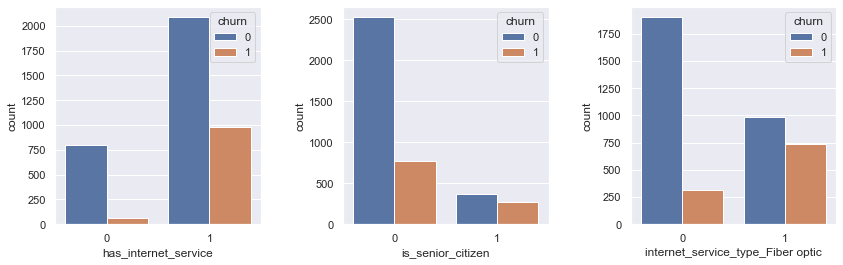

In [55]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(x = "has_internet_service", hue="churn" , ax=ax[0], data=df2)
sns.countplot(data = df2, x = "is_senior_citizen", ax=ax[1], hue="churn")
sns.countplot(data = df2, x ="internet_service_type_Fiber optic", ax=ax[2], hue="churn")
fig.show()

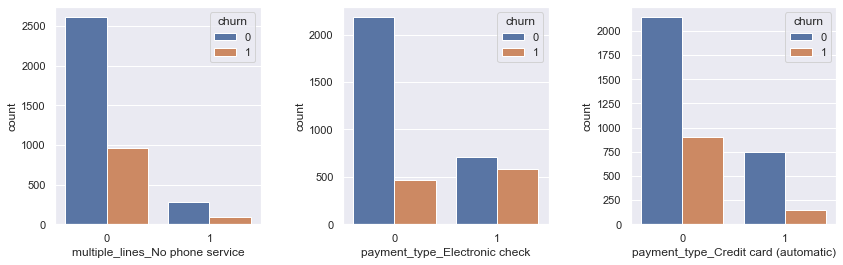

In [56]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(x = "multiple_lines_No phone service", hue="churn" , ax=ax[0], data=df2)
sns.countplot(data = df2, x = "payment_type_Electronic check", ax=ax[1], hue="churn")
sns.countplot(data = df2, x ="payment_type_Credit card (automatic)", ax=ax[2], hue="churn")
fig.show()

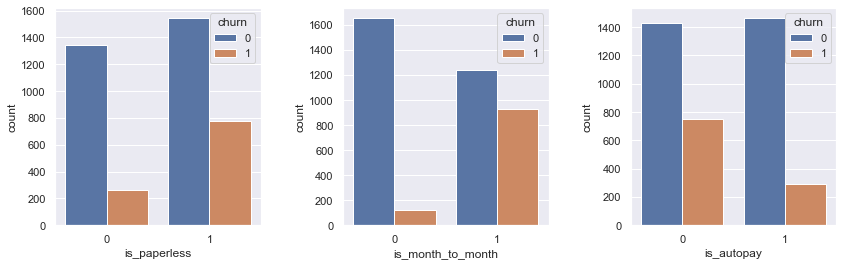

In [27]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(x = "is_paperless", hue="churn" , ax=ax[0], data=df2)
sns.countplot(data = df2, x = "is_month_to_month", ax=ax[1], hue="churn")
sns.countplot(data = df2, x ="is_autopay", ax=ax[2], hue="churn")
fig.show()

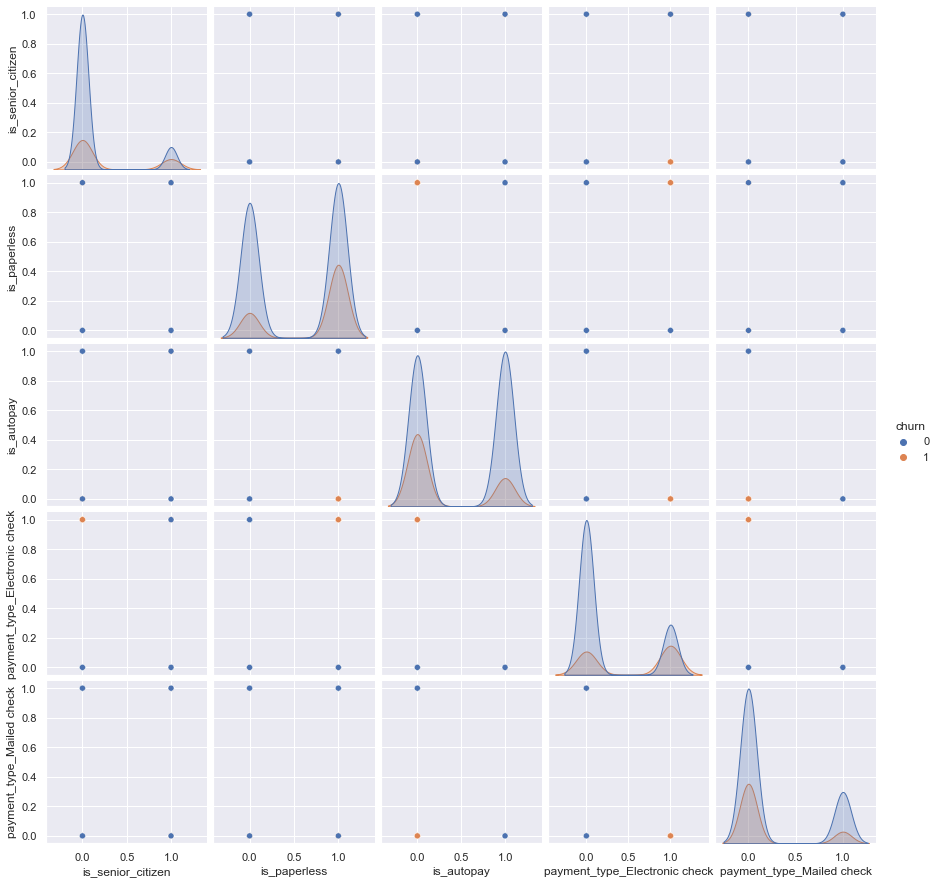

In [57]:
# When orange matches blue, you have churn rates as high as non-churn rates
cols = ['is_senior_citizen','is_paperless','churn','is_autopay','payment_type_Electronic check','payment_type_Mailed check']
pairplot_features = df2[cols]
sns.pairplot(pairplot_features, hue = 'churn')

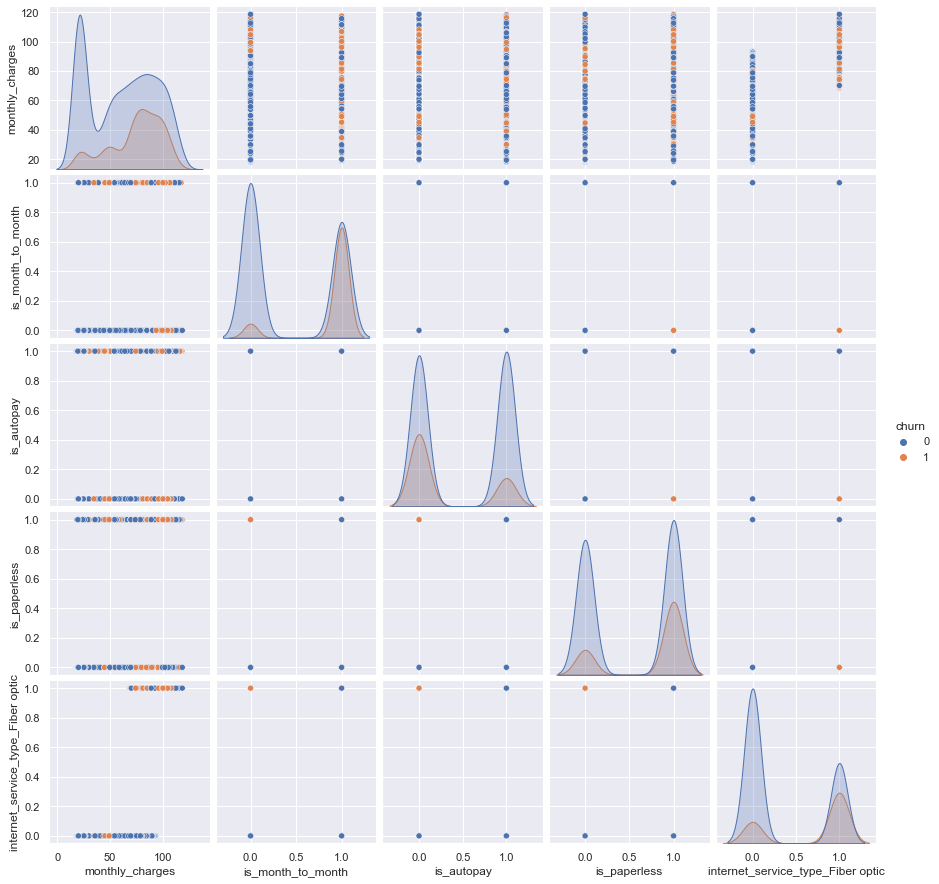

In [64]:
cols = ['monthly_charges','churn','is_month_to_month','is_autopay','is_paperless','internet_service_type_Fiber optic']
pairplot_features = df2[cols]
sns.pairplot(pairplot_features, hue = 'churn')

### <span style="color:red">Takeaway</span>

High churn rates:
- Month-to-month
- Fiber internet
- Electronic Checks

# Multivaite
### Starting with Chi^2 for relationships between categories
 - Specifically looking for relationship to churn
 - Exploring any relationships within data

In [30]:
chi2, p, degf, expected = stats.chi2_contingency(df2)

print('---\nExpected')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

---
Expected
[[2.95187813e-01 5.99840230e+01 1.18604046e+02 ... 4.16052114e-01
  5.99208017e-01 4.14192664e-01]
 [4.12091310e-01 8.37395500e+01 1.65574914e+02 ... 5.80821610e-01
  8.36512911e-01 5.78225759e-01]
 [6.36549216e-02 1.29350810e+01 2.55760262e+01 ... 8.97183540e-02
  1.29214479e-01 8.93173781e-02]
 ...
 [4.10036638e-02 8.33220278e+00 1.64749363e+01 ... 5.77925656e-02
  8.32342089e-02 5.75342748e-02]
 [1.37875775e-01 2.80172261e+01 5.53973575e+01 ... 1.94328849e-01
  2.79876968e-01 1.93460340e-01]
 [5.03693754e-03 1.02353744e+00 2.02380026e+00 ... 7.09930567e-03
  1.02245866e-02 7.06757693e-03]]
---

chi^2 = 1259265.7812
p     = 0.0000


In [31]:
results = pd.DataFrame(columns=['Features','Chi2Weights'])

for i in range (len(df2.columns)):
    chi2, p = stats.chisquare(df2[df2.columns[i]])
    results = results.append([pd.Series([df2.columns[i], chi2], index=results.columns)], ignore_index = True)

In [32]:
results = results.sort_values(by = "Chi2Weights", ascending = False)
results.head(20)

Features     Chi2Weights
3                           total_charges  8870285.286931
1                                  tenure    73323.163861
2                         monthly_charges    55741.929168
14        multiple_lines_No phone service          3564.0
0                       is_senior_citizen          3302.0
28                 contract_type_One year          3122.0
31             internet_service_type_None          3070.0
26   streaming_movies_No internet service          3070.0
24       streaming_tv_No internet service          3070.0
22       tech_support_No internet service          3070.0
20  device_protection_No internet service          3070.0
18      online_backup_No internet service          3070.0
16    online_security_No internet service          3070.0
34              payment_type_Mailed check          3046.0
32   payment_type_Credit card (automatic)          3042.0
29                 contract_type_Two year          2980.0
4                                   churn          2891.0
23                       tech_support_Yes          2798.0
17                    online_security_Yes          2785.0
9                           has_dependent          2745.0

In [33]:
chi_df = df2[results["Features"].head(20)]
chi_df.head()

total_charges  tenure  monthly_charges  multiple_lines_No phone service  \
5919        4299.20      58            71.10                                0   
1915        6028.95      71            85.45                                0   
5054         882.55      35            25.75                                0   
2355          19.20       1            19.20                                0   
6279        1055.90      20            54.00                                0   

      is_senior_citizen  contract_type_One year  internet_service_type_None  \
5919                  0                       1                           0   
1915                  0                       1                           0   
5054                  0                       0                           1   
2355                  0                       0                           1   
6279                  1                       1                           0   

      streaming_movies_No internet service  streaming_tv_No internet service  \
5919                                     0                                 0   
1915                                     0                                 0   
5054                                     1                                 1   
2355                                     1                                 1   
6279                                     0                                 0   

      tech_support_No internet service  device_protection_No internet service  \
5919                                 0                                      0   
1915                                 0                                      0   
5054                                 1                                      1   
2355                                 1                                      1   
6279                                 0                                      0   

      online_backup_No internet service  online_security_No internet service  \
5919                                  0                                    0   
1915                                  0                                    0   
5054                                  1                                    1   
2355                                  1                                    1   
6279                                  0                                    0   

      payment_type_Mailed check  payment_type_Credit card (automatic)  \
5919                          0                                     1   
1915                          0                                     1   
5054                          0                                     0   
2355                          1                                     0   
6279                          1                                     0   

      contract_type_Two year  churn  tech_support_Yes  online_security_Yes  \
5919                       0      0                 1                    1   
1915                       0      0                 0                    1   
5054                       0      0                 0                    0   
2355                       0      0                 0                    0   
6279                       0      0                 1                    1   

      has_dependent  
5919              0  
1915              1  
5054              1  
2355              1  
6279              0

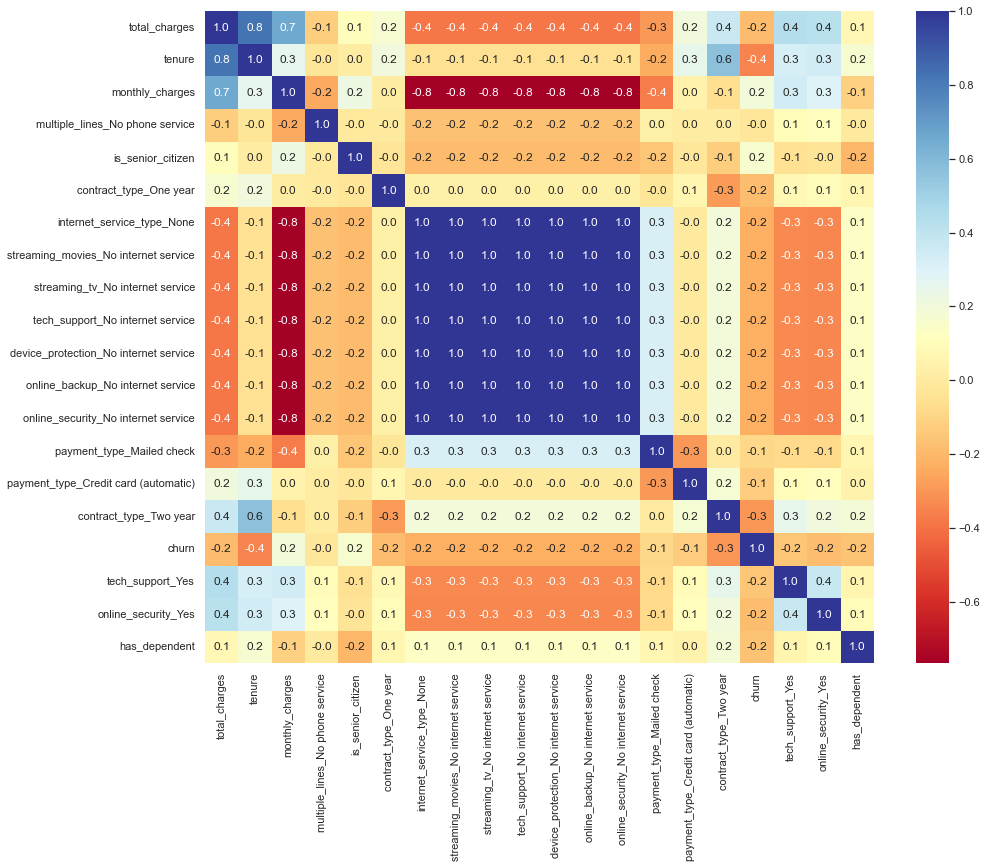

In [34]:
# Finding Correlation
plt.figure(figsize = (15, 12))
sns.heatmap(chi_df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

### <span style="color:green"> Takeaway from the heatmap:</span>
Correlated features:
- columns can be summarized  
    -'internet_service_type_None',
       'streaming_movies_No internet service',
       'streaming_tv_No internet service', 'tech_support_No internet service',
       'device_protection_No internet service',
       'online_security_No internet service',
       'online_backup_No internet service',


In [35]:
chi_df.columns

Index(['total_charges', 'tenure', 'monthly_charges',
       'multiple_lines_No phone service', 'is_senior_citizen',
       'contract_type_One year', 'internet_service_type_None',
       'streaming_movies_No internet service',
       'streaming_tv_No internet service', 'tech_support_No internet service',
       'device_protection_No internet service',
       'online_backup_No internet service',
       'online_security_No internet service', 'payment_type_Mailed check',
       'payment_type_Credit card (automatic)', 'contract_type_Two year',
       'churn', 'tech_support_Yes', 'online_security_Yes', 'has_dependent'],
      dtype='object')

In [48]:
# Reacccomplish with removing 'no internet service' features
chi2, p, degf, expected = stats.chi2_contingency(chi_df)

print('---\nExpected')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

---
Expected
[[4.24870815e+03 6.01060791e+01 1.18845383e+02 ... 5.30556001e-01
  5.36611513e-01 5.55243857e-01]
 [5.93302670e+03 8.39339770e+01 1.65959346e+02 ... 7.40884713e-01
  7.49340816e-01 7.75359594e-01]
 [9.06144398e+02 1.28191405e+01 2.53467816e+01 ... 1.13154477e-01
  1.14445968e-01 1.18419786e-01]
 ...
 [5.81521738e+02 8.22673395e+00 1.62663970e+01 ... 7.26173314e-02
  7.34461508e-02 7.59963644e-02]
 [1.97706847e+03 2.79694037e+01 5.53028003e+01 ... 2.46885760e-01
  2.49703595e-01 2.58373859e-01]
 [6.39851249e+01 9.05191612e-01 1.78979972e+00 ... 7.99012094e-03
  8.08131635e-03 8.36191762e-03]]
---

chi^2 = 859460.6060
p     = 0.0000


In [49]:
results = pd.DataFrame(columns=['Features','Chi2Weights'])

for i in range (len(chi_df.columns)):
    chi2, p = stats.chisquare(chi_df[chi_df.columns[i]])
    results = results.append([pd.Series([chi_df.columns[i], chi2], index=results.columns)], ignore_index = True)

In [50]:
results = results.sort_values(by = "Chi2Weights", ascending = False)
results.head(20)

Features     Chi2Weights
0                          total_charges  8870285.286931
1                                 tenure    73323.163861
2                        monthly_charges    55741.929168
3        multiple_lines_No phone service          3564.0
4                      is_senior_citizen          3302.0
5                 contract_type_One year          3122.0
6             internet_service_type_None          3070.0
7              payment_type_Mailed check          3046.0
8   payment_type_Credit card (automatic)          3042.0
9                 contract_type_Two year          2980.0
10                                 churn          2891.0
11                      tech_support_Yes          2798.0
12                   online_security_Yes          2785.0
13                         has_dependent          2745.0

In [36]:
neg_corr_feature = ['streaming_movies_No internet service',
 'streaming_tv_No internet service', 'tech_support_No internet service',
 'device_protection_No internet service',
 'online_security_No internet service',
 'online_backup_No internet service',]

def remove_corr_features(features):
    for feature in features:
        del chi_df[feature]

In [37]:
remove_corr_features(neg_corr_feature)

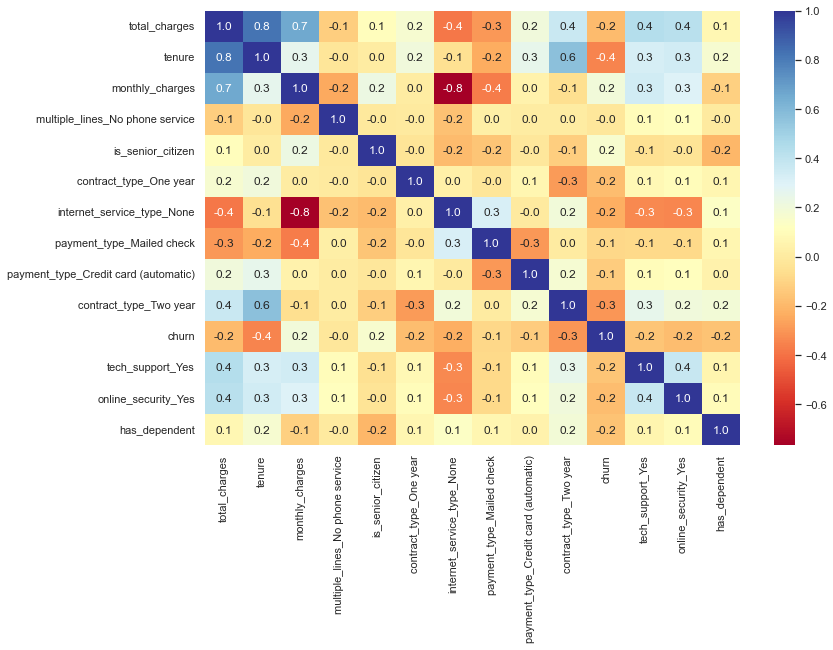

In [38]:
plt.figure(figsize = (12, 8))
sns.heatmap(chi_df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

### Outlier Detection

In [39]:
trace = []

def gen_boxplot(df):
    for feature in df:
        trace.append(
            go.Box(
                name = feature,
                y = df[feature]
            )
        )
        
gen_boxplot(chi_df)

In [40]:
data = trace
plotly.offline.iplot(data)

### <span style="color:green">Take away: Outlier detection not useful</span>

### Trying eli5 method

In [41]:
# Baseline churn rate
baseline_churn = (df2.churn == 1).mean()
print(baseline_churn)

0.2656845313690627


In [42]:
df2.columns

Index(['is_senior_citizen', 'tenure', 'monthly_charges', 'total_charges',
       'churn', 'is_male', 'has_phone', 'has_internet_service', 'has_partner',
       'has_dependent', 'is_paperless', 'is_month_to_month', 'is_autopay',
       'has_streaming', 'multiple_lines_No phone service',
       'multiple_lines_Yes', 'online_security_No internet service',
       'online_security_Yes', 'online_backup_No internet service',
       'online_backup_Yes', 'device_protection_No internet service',
       'device_protection_Yes', 'tech_support_No internet service',
       'tech_support_Yes', 'streaming_tv_No internet service',
       'streaming_tv_Yes', 'streaming_movies_No internet service',
       'streaming_movies_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', 'payment_type_Credit card (automatic)',
       'payment_type_Electronic check', 'payment_type_Mailed check'],
      dtype='object')

In [43]:
customer_group = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent']
business_group = ['is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service','has_streaming']

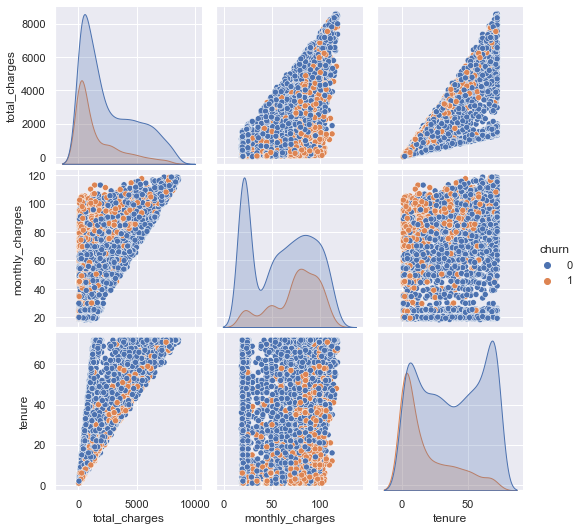

In [44]:
cols = ['total_charges', 'monthly_charges', 'tenure', 'churn']
pairplot_feature = df2[cols]
sns.pairplot(pairplot_feature, hue = 'churn')

In [45]:
x = df2.drop('churn', axis =1)
y= df2['churn']

clf = RandomForestClassifier(random_state =123).fit(x,y)

In [46]:
# Need eli5 to show weights of permutations
from eli5.sklearn import PermutationImportance

In [47]:
perm = PermutationImportance(clf, random_state = 123). fit(x,y)
eli5.show_weights(perm, feature_names = x.columns.tolist())

## <span style="color:red">Overall EDA Takeaways & Questions answered:</span>

### Data Question:
 - What customer factors are available in the data?
 - What business factors are available in the data?

Customer groups
 - Senior citizen
 - Male vs. Female
 - Partner vs. No Partner
 - Dependent vs No Dependents

Business Groups
 - Auto vs Manual Pay
 - paperless billing vs mailed
 - month-to-month vs contracted
 - Internet vs no Internet
 - Phone vs No phone
 
 What Factors contribute the most to churn from customers?
  - is male (not significant)
  - has partner (not significant)
  
What factors from the business have the highest contribution to churn?
  - Fiber optic Internet service
  - Electronic Check
  - Paperless billing
  
 ### Project Questions:

- Is churn customer or feature driven?
    - Feature
    
- Are any groups of churn higher than the average rate? 
    a. Of those groups, are there any subgroups who churn? 
        - has_phone_service_Yes, has_multiple_lines_No phone service', has_paperless_billing_Yes,
        - internet_service_type_Fiber optic, payment_type_Electronic check
    b. What services lead to higher churn?
        - internet_service_type_Fiber optic, payment_type_Electronic check

- Is there a significant difference between the internet and phone services for those who churn?
    - Fiber optic has most significance when determining Churn
    
- Is there a significant difference between payment methods that drive churn?
    - Electronic Checks have strong significance when determining Churn